**<a href="https://www.kaggle.com/c/advanced-dls-spring-2021/">Предсказание оттока Kaggle</a>**

# Задание

_Заданием является предсказание (моделировование) оттока клиентов телеком компании в датасете test.csv (содержит только признаки), используя тренировачный датасет train.csv (содержит признаки и целевую пременную)._
    
    
**Материалы к проекту (файлы):**
* [train.csv](https://www.kaggle.com/c/advanced-dls-spring-2021/data?select=train.csv),
* [test.csv](https://www.kaggle.com/c/advanced-dls-spring-2021/data?select=test.csv),
* [sample_submission.csv](https://www.kaggle.com/c/advanced-dls-spring-2021/data?select=submission.csv)

**Целевая переменная:**
Churn (Отток: 1 или 0)

**Основная метрика:**
ROC-AUC (sklearn.metrics.roc_auc_score)

# Загрузка блиблиотек

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})

# Загрузка данных

In [2]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'
SUBMIT_DATASET_PATH = './submission.csv'
SUBMIT_FILE_PATH = './'
SUBMIT_FILE_NAME = 'predictions.csv'

In [3]:
data_train = pd.read_csv(TRAIN_DATASET_PATH)
data_test = pd.read_csv(TEST_DATASET_PATH)
data_submit = pd.read_csv(SUBMIT_DATASET_PATH)
data_train.shape, data_test.shape, data_submit.shape

((5282, 20), (1761, 19), (1761, 2))

# 1.&nbsp;Анализ данных


### Описание признаков
* **ClientPeriod** - время пользования клиентом услугами компании (в месяцах)
* **MonthlySpending** - ежемесячные траты клиента
* **TotalSpent** - общие траты клиента
* **Sex** - пол (ж/м)
* **IsSeniorCitizen** - пенсионер (да/нет)
* **HasPartner** - в браке (да/нет)
* **HasChild** - дети (есть/нет)
* **HasPhoneService** - телефонная связь (да/нет)
* **HasMultiplePhoneNumbers** - несколько номеров телефона (да/нет/не подключена телефонная связя)
* **HasInternetService** - интернет (нет/DSL/Fiber)
* **HasOnlineSecurityService** - средство охраны (да/нет/не подключено)
* **HasOnlineBackup** - облачное хранилище (да/нет/не подключен интернет)
* **HasDeviceProtection** - защита устройства (да/нет/не подключен интернет)
* **HasTechSupportAccess** - тех. поддержка (да/нет/не подключен интернет)
* **HasOnlineTV** - онлайн ТВ (да/нет/не подключен интернет)
* **HasMovieSubscription** - подписка на фильмы (да/нет/не подключен интернет)
* **HasContractPhone** - телефон по договору (месяц/год/2 года)
* **IsBillingPaperless** - оплата онлайн (да/нет)
* **PaymentMethod** - способ оплаты (кредитная карта/квитанция/банковский перевод/оплата онлайн)

In [4]:
data_train.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

Видим, что у количественного признака `TotalSpent` нечисловой тип данных. Возможно есть какие-то некорректные значения.

In [6]:
cat_cols = ['Sex', 'IsSeniorCitizen', 'HasPartner', 'HasChild', 'HasPhoneService',
           'HasMultiplePhoneNumbers', 'HasInternetService',
           'HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection',
           'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription',
           'HasContractPhone', 'IsBillingPaperless', 'PaymentMethod']
num_cols = ['ClientPeriod', 'MonthlySpending', 'TotalSpent']
target = ['Churn']

### Пропуски, выбросы, дубликаты

**Пропуски**

In [7]:
print(f"Тренировочный датасет: {sum(data_train.isna().sum())}")
print(f"Тестовый датасет: {sum(data_test.isna().sum())}")

Тренировочный датасет: 0
Тестовый датасет: 0


**Дубликаты**

In [8]:
print(f"Тренировочный датасет: {data_train.duplicated().sum()}")
print(f"Тестовый датасет: {data_test.duplicated().sum()}")

Тренировочный датасет: 14
Тестовый датасет: 3


In [9]:
print(f"Тренировочный датасет: {data_train.drop('Churn', axis=1).duplicated().sum()}")

Тренировочный датасет: 22


**Аномалии**

У `TotalSpent` странный тип, нужно проверить.

In [10]:
data_train_numeric = data_train['TotalSpent'].apply(pd.to_numeric, errors='coerce')
data_train[data_train_numeric.isna()]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


In [11]:
data_test_numeric = data_test['TotalSpent'].apply(pd.to_numeric, errors='coerce')
data_test.TotalSpent[data_test_numeric.isna()]

177     
767     
Name: TotalSpent, dtype: object

* Пропусков нет.
* В датасетах есть дубликаты, причем даже такие, что у одного объекта с одинаковыми признаками разные значения целевой переменной
* В признаке `TotalSpent` есть пустые значения.

### Целевая переменная

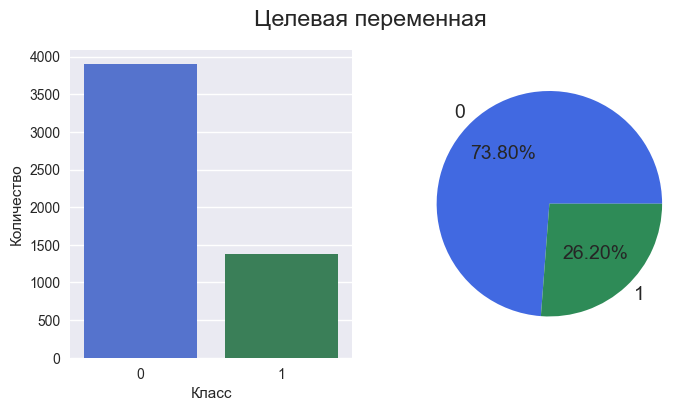

In [12]:
counts = data_train[target[0]].value_counts()

plt.style.use('seaborn')
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=False)
fig.suptitle('Целевая переменная')

sns.barplot(ax=axes[0], x=counts.index, y=counts.values, palette=['royalblue', 'seagreen'])
axes[0].set_xlabel('Класс')
axes[0].set_ylabel('Количество')

axes[1].pie(counts.values, autopct="%.2f%%", labels=counts.index, colors=['royalblue', 'seagreen'], textprops={'fontsize': 14})
None

В датасете есть дисбаланс классов целевой переменной.

### Количественные признаки

In [13]:
data_train_numeric = data_train[num_cols + target]
data_train_numeric.TotalSpent = data_train_numeric.TotalSpent.replace(' ', '0').astype('float')

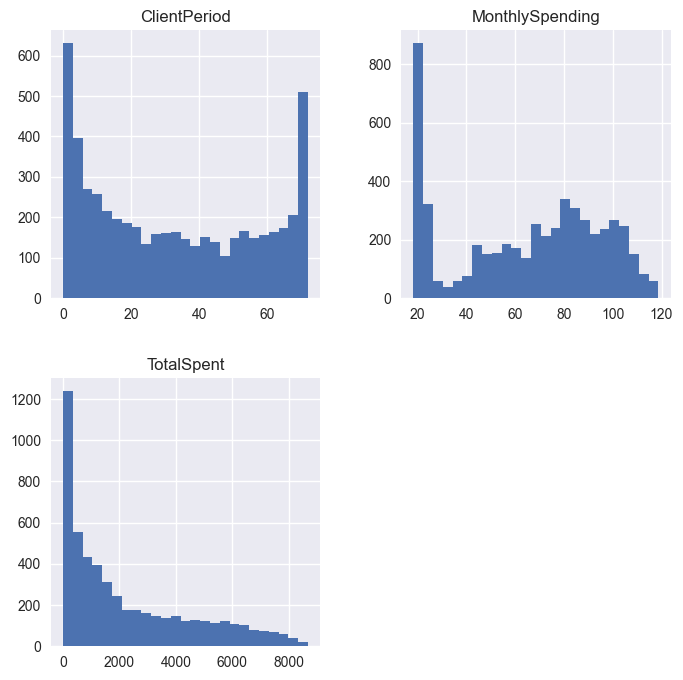

In [14]:
data_train_numeric[num_cols].hist(figsize=(8,8), bins=25, grid=True)
plt.show()

In [15]:
data_train_numeric[num_cols].describe()

,ClientPeriod,MonthlySpending,TotalSpent
count,5282.000000,5282.000000,5282.000000
mean,32.397009,64.924754,2287.486161
std,24.550326,30.176464,2269.049195
min,0.000000,18.250000,0.000000
25%,9.000000,35.462500,395.725000
50%,29.000000,70.400000,1405.650000
75%,55.000000,90.050000,3795.212500
max,72.000000,118.750000,8684.800000


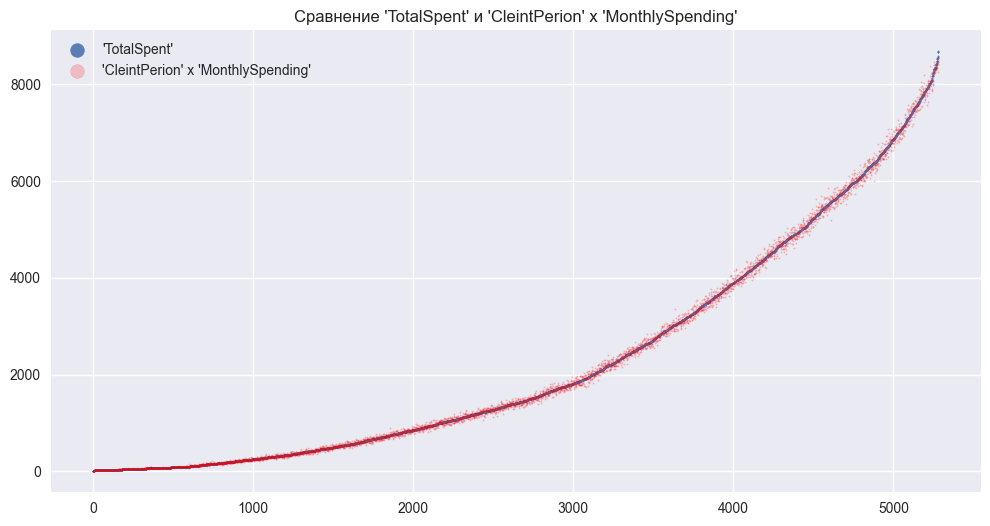

In [16]:
x = np.arange(data_train_numeric.shape[0])
y_1 = data_train_numeric.sort_values(by='TotalSpent')
y_2 = data_train_numeric.sort_values(by='TotalSpent')
y_2 = y_2.ClientPeriod * y_2.MonthlySpending
plt.figure(figsize=(12,6))
plt.title("Сравнение 'TotalSpent' и 'CleintPerion' x 'MonthlySpending'")
plt.scatter(x, y_1.TotalSpent, alpha=0.9, s=1)
plt.scatter(x, y_2, color='red', alpha=0.2, s=1)
plt.legend(["'TotalSpent'", "'CleintPerion' x 'MonthlySpending'"], markerscale=10.)
plt.grid(True)
plt.show()

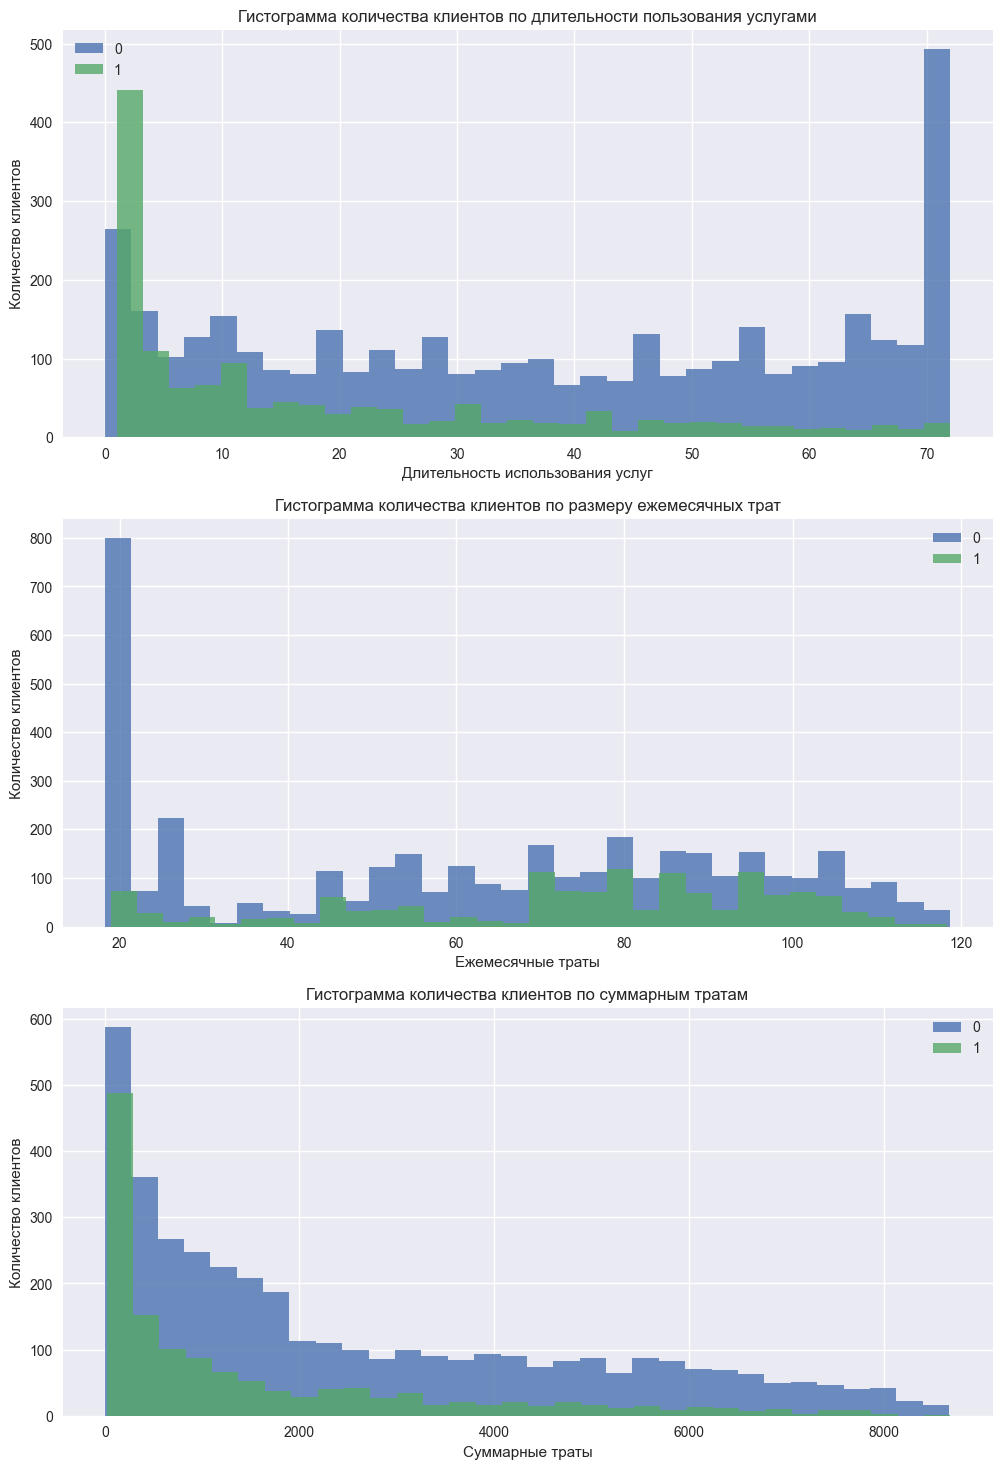

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 18))
binsL = [32, 32, 32]
xlabels = ['Длительность использования услуг', 'Ежемесячные траты', 'Суммарные траты']
titles = ['Гистограмма количества клиентов по длительности пользования услугами',
          'Гистограмма количества клиентов по размеру ежемесячных трат',
          'Гистограмма количества клиентов по суммарным тратам']
for i in range(3):
    axes[i].set_title(titles[i])
    data_train_numeric.groupby('Churn')[num_cols[i]].plot(kind='hist', bins=binsL[i], alpha=0.8, ax=axes[i])
    axes[i].legend(['0', '1'])
    axes[i].set_xlabel(xlabels[i])
    axes[i].set_ylabel('Количество клиентов')

None

* По полученным гистограммам можно сделать вывод, что более давние пользователи реже отказываются от услуг.
* Также видна зависимость между `ClientPeriod`, `MonthlySpending`, `TotalSpent`.
* Выбросов нет, есть несколько некорректных значений.
* Пропусков нет.

### Категориальные признаки

In [18]:
data_train_cat = data_train[cat_cols]

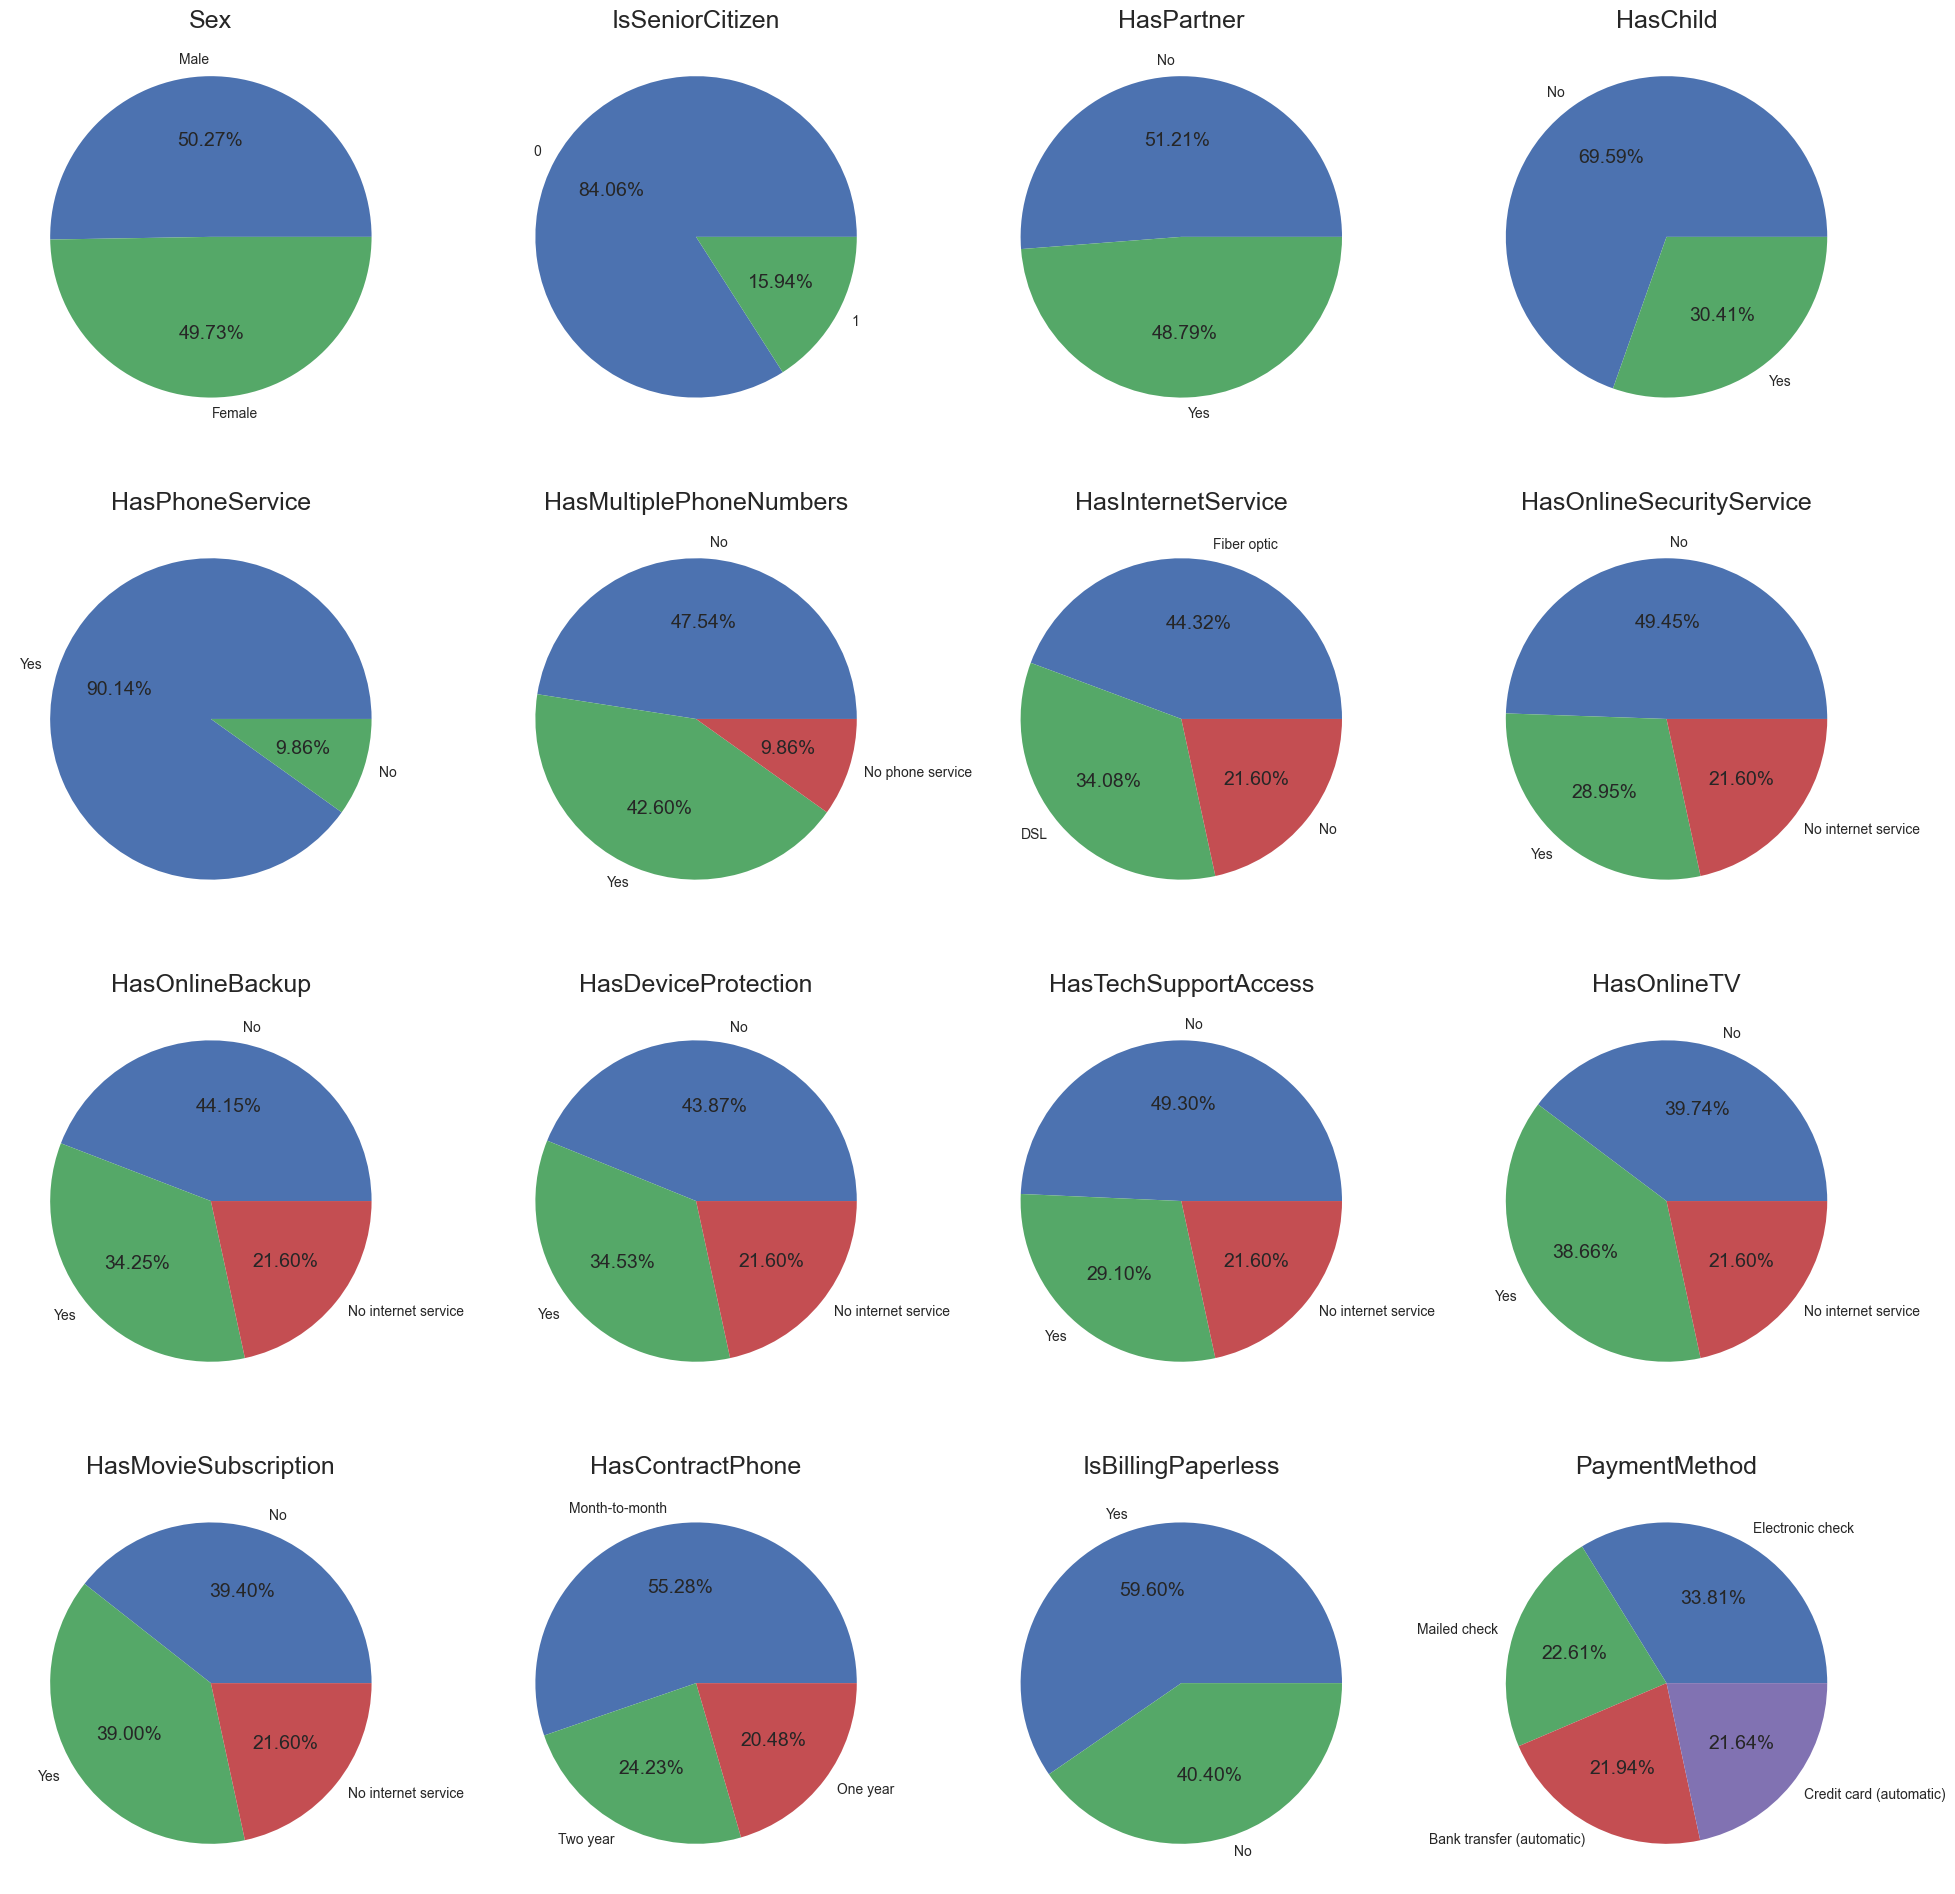

In [19]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(24, 24))
for ax, col in zip(axes.flatten(), data_train_cat.columns):
    ax.set_title(col, fontdict={'fontsize': 18})
    counts = data_train_cat[col].value_counts()
    ax.pie(counts.values, autopct="%.2f%%", labels=counts.index)


### Матрица корреляций

In [20]:
word_to_number = {
    "No": 0,
    "No internet service": 0,
    "No phone service": 0,
    "Yes": 1,
    "Male": 0,
    "Female": 1,
    "DSL": 1,
    "Fiber optic": 2,
    "Month-to-month": 0,
    "One year": 1,
    "Two year": 2,
    "Credit card (automatic)": 0,
    "Bank transfer (automatic)": 1,
    "Mailed check": 2,
    "Electronic check": 3,
}
data_train_matrix = data_train.replace(word_to_number)
data_train_matrix.TotalSpent = data_train_matrix.TotalSpent.replace(' ', '0').astype('float')

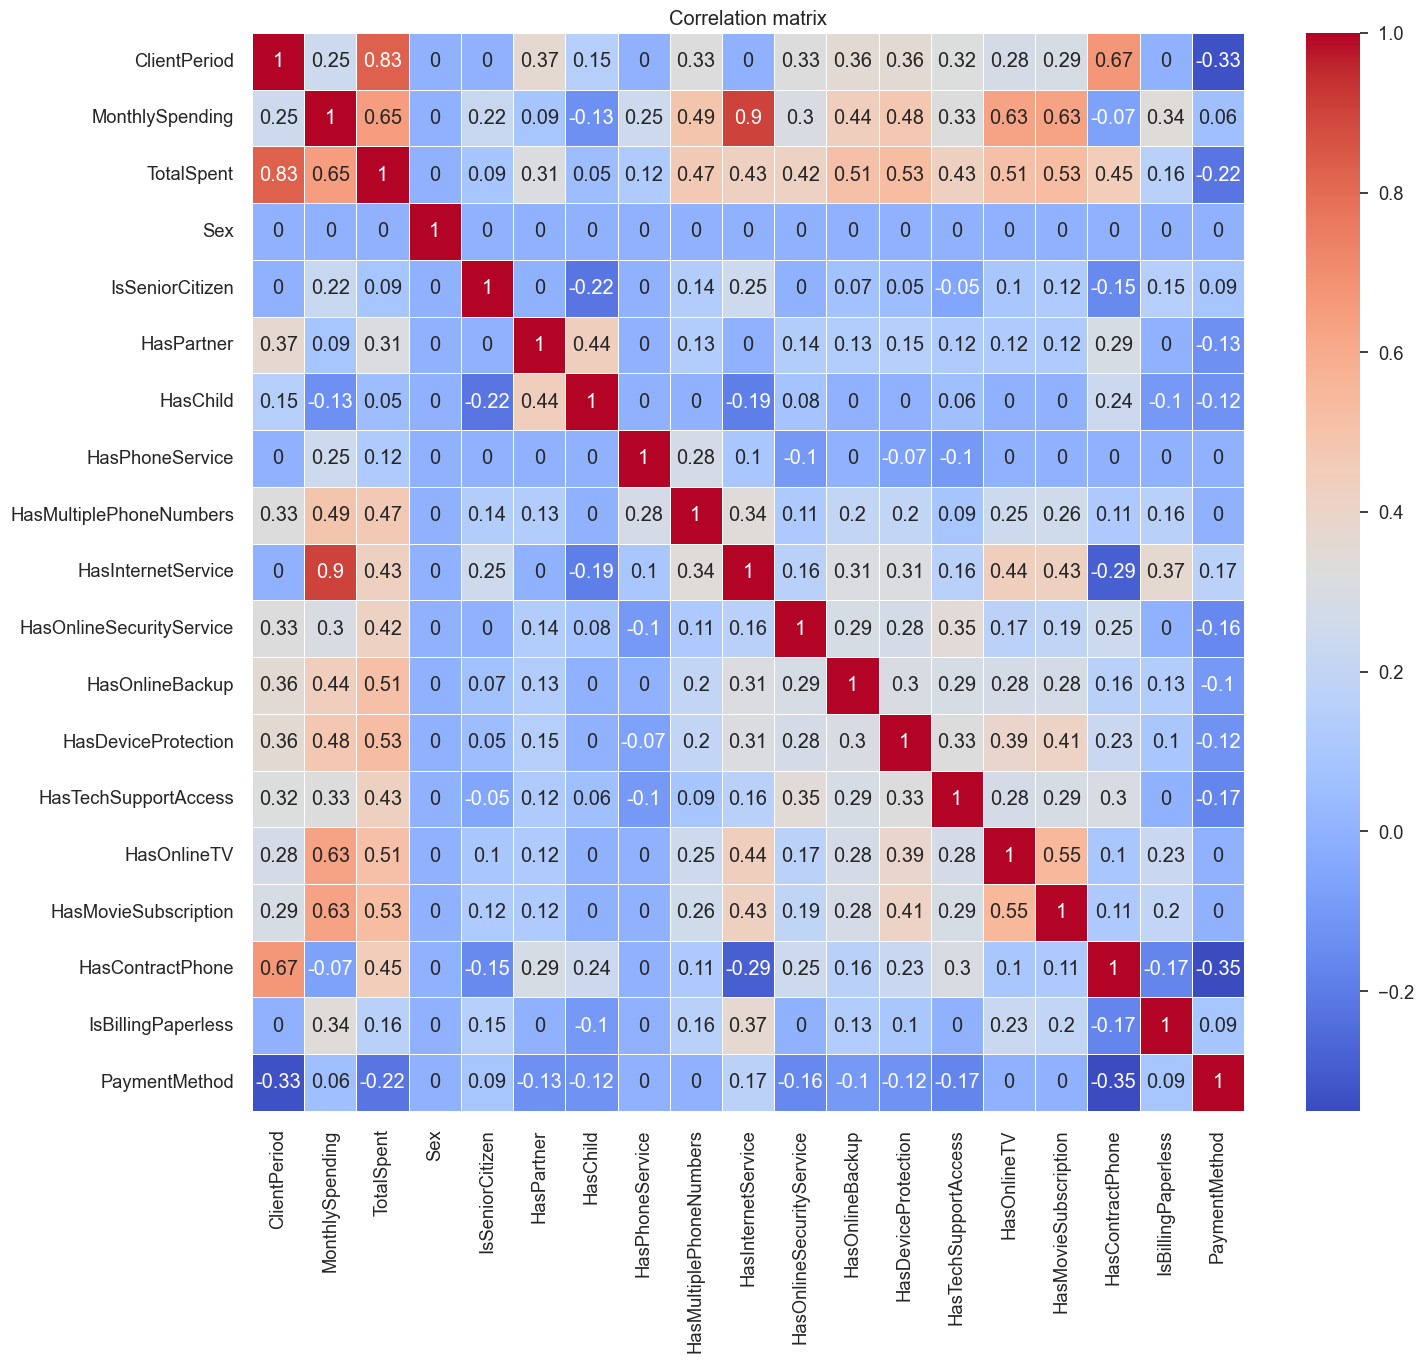

In [21]:
plt.figure(figsize = (16,14))
sns.set(font_scale=1.2)

corr_matrix = data_train_matrix.drop(columns='Churn').corr()
corr_matrix = data_train_matrix.drop(columns='Churn').corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.05] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

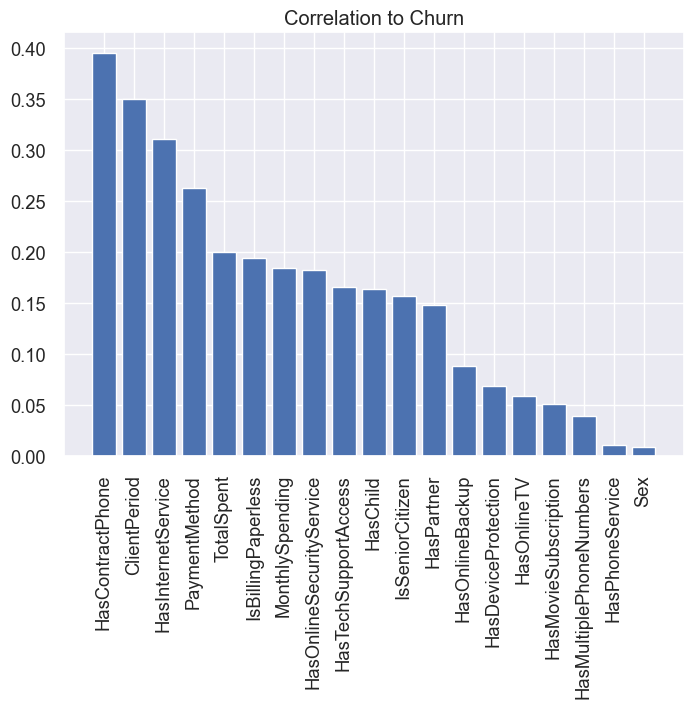

In [22]:
corr_matrix = data_train_matrix.corrwith(
    data_train_matrix['Churn']).abs().sort_values(ascending=False)[1:]
plt.bar(corr_matrix.index, corr_matrix.values)
plt.title('Correlation to Churn')
plt.xticks(rotation='vertical')
plt.show()

# 2.&nbsp;Обработка и подготовка данных

* Дубликаты
* Некорректные значения `TotalSpent`

In [23]:
def total_spent_preprocessing(df):
    """
    Меняем ' ' в колонке 'TotalSpent' на произведение 'ClientPeriod' и
    'MonthlySpending', устанавливаем числовой тип данных.
    """
    mask = df['TotalSpent'].apply(pd.to_numeric, errors='coerce').isna()
    df.loc[mask, 'TotalSpent'] = df.loc[mask, 'ClientPeriod'] * df.loc[mask, 'MonthlySpending']
    df['TotalSpent']= df['TotalSpent'].astype('float')
    return df

def delete_duplicates_for_train_dataset(df, subset):
    """
    Удаление дубликатов.
        subset - колонки, по которым определяется дубликат.
    """
    df = df.drop_duplicates(subset=subset)
    return df

In [24]:
cat_cols = ['Sex', 'IsSeniorCitizen', 'HasPartner', 'HasChild', 'HasPhoneService',
           'HasMultiplePhoneNumbers', 'HasInternetService',
           'HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection',
           'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription',
           'HasContractPhone', 'IsBillingPaperless', 'PaymentMethod']
num_cols = ['ClientPeriod', 'MonthlySpending', 'TotalSpent']
target = ['Churn']

In [25]:
processed_data_train = total_spent_preprocessing(data_train)
processed_data_train = delete_duplicates_for_train_dataset(processed_data_train, num_cols + cat_cols)

In [26]:
X_train, y_train = processed_data_train[num_cols + cat_cols], processed_data_train[target]

In [27]:
X_train.shape, y_train.shape

((5260, 19), (5260, 1))

In [28]:
processed_data_test = total_spent_preprocessing(data_test)
processed_data_test.shape, data_test.shape

((1761, 19), (1761, 19))

# 3.&nbsp;Моделирование

In [29]:
best_models = pd.DataFrame({'Model':[], 'Score':[], 'Best params':[]})
best_models

,Model,Score,Best params


### LogRegression

In [30]:
# OHE для категориальных признаков
cat_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first', handle_unknown='error')),
])

# Нормировка данных для числовых признаков
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
])

# Объединение
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_cols),
        ('num', num_transformer, num_cols),
    ])

# Итоговый pipeline
log_regression_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', LogisticRegression(random_state=102))])

In [31]:
param_grid = {'model__C': [100, 10, 1, 0.1, 0.01, 0.001],
              'model__penalty': ['l1', 'l2'],
              'model__solver': ['liblinear'],
              'model__max_iter': [25, 50, 100, 150, 200]
             }

log_regression_cv = GridSearchCV(log_regression_pipe,
                                 param_grid,
                                 cv=5,
                                 scoring='roc_auc',
                                 n_jobs=-1)

log_regression_cv.fit(X_train, y_train)

print(f"Best score: {log_regression_cv.best_score_}")
print(f"Best params: {log_regression_cv.best_params_}")

Best score: 0.8450771176669786
Best params: {'model__C': 100, 'model__max_iter': 50, 'model__penalty': 'l1', 'model__solver': 'liblinear'}


In [32]:
best_models.loc[len(best_models.index)] = ['LogisticRegression', log_regression_cv.best_score_, log_regression_cv.best_params_]

### RandomForestClassifier

In [33]:
# OHE для категориальных признаков
cat_transformer = Pipeline(steps=[
    ('ordinal_encoder', OneHotEncoder()),
])

# Нормировка данных для числовых признаков
num_transformer = Pipeline(steps=[
   ('scaler', StandardScaler()),
])

# Объединение
preprocessor = ColumnTransformer(
   transformers=[
       ('cat', cat_transformer, cat_cols),
       ('num', num_transformer, num_cols),
   ])

# Итоговый pipeline
random_forest_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', RandomForestClassifier(random_state=102))])

In [34]:
param_grid = {'model__max_depth': range(1, 11, 1),
              'model__max_features': ["sqrt", "log2"],
              'model__n_estimators': [100, 150, 200],
              'model__min_samples_leaf': range(2, 8, 1),
              'model__min_samples_split': [3, 5, 7]
             }

random_forest_cv = GridSearchCV(random_forest_pipe,
                                param_grid,
                                cv=5,
                                scoring='roc_auc',
                                n_jobs=-1)

random_forest_cv.fit(X_train, y_train)

print(f"Best score: {random_forest_cv.best_score_}")
print(f"Best params: {random_forest_cv.best_params_}")

Best score: 0.8445918639298495
Best params: {'model__max_depth': 7, 'model__max_features': 'log2', 'model__min_samples_leaf': 7, 'model__min_samples_split': 3, 'model__n_estimators': 200}


In [35]:
best_models.loc[len(best_models.index)] = ['RandomForestClassifier', random_forest_cv.best_score_, random_forest_cv.best_params_]

### GradientBoostingClassifier

In [36]:
# OHE для категориальных признаков
cat_transformer = Pipeline(steps=[
    ('ordinal_encoder', OneHotEncoder()),
])

# Нормировка данных для числовых признаков
num_transformer = Pipeline(steps=[
   ('scaler', StandardScaler()),
])

# Объединение
preprocessor = ColumnTransformer(
   transformers=[
       ('cat', cat_transformer, cat_cols),
       ('num', num_transformer, num_cols),
   ])

# Итоговый pipeline
gbc_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', GradientBoostingClassifier())])

In [37]:
param_grid = {'model__n_estimators': [100, 150, 200],
              'model__max_features': [None, "sqrt", "log2"],
              'model__max_depth': [3, 5, 7, 9, 11],
              'model__min_samples_leaf': [2, 4, 5, 8],
              'model__learning_rate': [0.01, 0.025, 0.05, 0.1]
             }

gbc_cv = GridSearchCV(gbc_pipe,
                      param_grid,
                      cv=5,
                      scoring='roc_auc',
                      n_jobs=-1)

gbc_cv.fit(X_train, y_train)

print(f"Best score: {gbc_cv.best_score_}")
print(f"Best params: {gbc_cv.best_params_}")

Best score: 0.8476002063176326
Best params: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 2, 'model__n_estimators': 100}


In [38]:
best_models.loc[len(best_models.index)] = ['GradientBoostingClassifier', gbc_cv.best_score_, gbc_cv.best_params_]

### CatBoostClassifier

In [39]:
param_grid = {'depth': [2, 3, 4, 5],
              'l2_leaf_reg': [0.1, 0.5, 1, 3],
              'subsample': [0.5, 0.6, 1],
              'n_estimators': [500, 750, 1000],
              'learning_rate':[0.005, 0.01, 0.025, 0.05]
              }

catboost_cv = GridSearchCV(estimator=CatBoostClassifier(cat_features=cat_cols,
                                                        eval_metric="AUC:hints=skip_train~false",
                                                        verbose = 0),
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=5,
                           n_jobs=-1)

catboost_cv.fit(X_train, y_train)

print(f"Best score: {catboost_cv.best_score_}")
print(f"Best params: {catboost_cv.best_params_}")

Best score: 0.848427615635414
Best params: {'depth': 3, 'l2_leaf_reg': 1, 'learning_rate': 0.025, 'n_estimators': 500, 'subsample': 0.6}


In [40]:
best_models.loc[len(best_models.index)] = ['CatBoostClassifier', catboost_cv.best_score_, catboost_cv.best_params_]

# 4.&nbsp;Оценка

In [41]:
best_models = best_models.sort_values(by=['Score'], ascending=False)
best_models

,Model,Score,Best params
3,CatBoostClassifier,0.848428,"{'depth': 3, 'l2_leaf_reg': 1, 'learning_rate'..."
2,GradientBoostingClassifier,0.847600,"{'model__learning_rate': 0.05, 'model__max_dep..."
0,LogisticRegression,0.845077,"{'model__C': 100, 'model__max_iter': 50, 'mode..."
1,RandomForestClassifier,0.844592,"{'model__max_depth': 7, 'model__max_features':..."


**Вывод:** Лучший результат показала модель `CatBoostClassifier`, поэтому для предсказания на тестовом датасете применим именно ее.

# 5.&nbsp;Прогнозирование на тестовом датасете

In [42]:
best_model = CatBoostClassifier(**best_models.iloc[0]['Best params'], cat_features=cat_cols, verbose = 500)
best_model.fit(X_train, y_train)

0:	learn: 0.6797181	total: 5.82ms	remaining: 2.9s
499:	learn: 0.3947818	total: 2.64s	remaining: 0us


In [43]:
predictions = best_model.predict_proba(processed_data_test)

In [44]:
predictions[:, 1].shape[0] == data_submit[target[0]].shape[0]

True

In [45]:
data_submit[target[0]] = predictions[:, 1]

In [46]:
data_submit.to_csv(SUBMIT_FILE_PATH + best_models.iloc[0]['Model'] + '_' + SUBMIT_FILE_NAME, index=False)

---